In [ ]:
%load_ext autoreload
%autoreload 2
#%env CUDA_VISIBLE_DEVICES=3

#### Download packages if in Google Colab

In [ ]:
colab_requirements = [
    "pip install librosa",
    "pip install noisereduce",
    "pip install soundfile",

]

import sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

# Test noise reduction algorithm and view steps of algorithm

In [ ]:
#we import everything you need to work
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
from scipy import signal as sg
from scipy.signal import find_peaks
from tensorflow.keras.models import load_model
%matplotlib inline

### Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#we define function that we will use later
def read(filename):                               #to read audios
    rate, data = wavfile.read(filename)
    length = data.shape[0] / rate
    time = np.linspace(0, length, data.shape[0], endpoint=False)
    return time, data

def normalizar(señal):                 #normalize the signal
    a = señal - np.mean(señal)
    a = a / np.std(a)
    señal_norm = a/max(a)
    return señal_norm

 #we will need filters to smoth the signal    

def filtro_pb (señal, fs, N, fc):              #low-pass filter                
    ### Filtro Pasabajo Butterworth ###
    # Es conveniente usar *sosfiltfilt*
	#b, a = sg.butter(N, f_c / (fs / 2), 'low')
    #señal_fil = sg.filtfilt(b, a, señal)
    sos = sg.butter(N, fc / (fs / 2), 'low', output='sos')
    señal_fil = sg.sosfiltfilt(sos, señal)
    return señal_fil

def filtro_pa (señal, fs, N, fc):    #high-pass filter
    ### Filtro Pasaalto Butterworth ###
	# Es conveniente usar *sosfiltfilt*
    #b, a = sg.butter(N, f_c / (fs / 2), 'highpass')
	#señal_fil = sg.filtfilt(b, a, señal)
    sos = sg.butter(N, fc / (fs / 2), 'highpass', output='sos')
    señal_fil = sg.sosfiltfilt(sos, señal)
    return señal_fil

In [ ]:
#url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/fish.wav"
#response = urllib.request.urlopen(url)
archivo1="/content/drive/MyDrive/LABO 6 y 7/Diciembre/Audios/med3_m1.wav"    #we indicate were is the signal, and we called "archivo_i", where i index from 1 to 4, the microphone
archivo2='/content/drive/MyDrive/LABO 6 y 7/Diciembre/Audios/med3_m2.wav'    #so, archivo 2 is the signal in the microphone 2
archivo3='/content/drive/MyDrive/LABO 6 y 7/Diciembre/Audios/med3_m3.wav'          #signal in the microphone 3 
archivo4='/content/drive/MyDrive/LABO 6 y 7/Diciembre/Audios/med3_m4.wav'          #signal in the microphone 4

time1a, data1a = read(archivo1)#now, we read the signals
time2a, data2a = read(archivo2)
time3a, data3a = read(archivo3)
time4a, data4a = read(archivo4)

#7 a 9 4 seg ---> hay resultados
#7 a 15 18 seg ---> muy ruidoso
#7 a 12 11 seg ---> muy ruidoso
# 7 a 10 ok


data1a, rate1 = sf.read(archivo1)
data1 = data1a[893000:972900]            # this is to select a region in the signal, usually our region of interest
time1 = time1a[893000:972900]

data2a, rate2 = sf.read(archivo2)
data2 = data2a[893000:972900]
time2 = time2a[893000:972900]

data3a, rate3 = sf.read(archivo3)
data3 = data3a[893000:972900]
time3 = time3a[893000:972900]

data4a, rate4 = sf.read(archivo4)
data4 = data4a[893000:972900]
time4 = time4a[893000:972900]

In [ ]:
IPython.display.Audio(data=data1, rate=rate1)

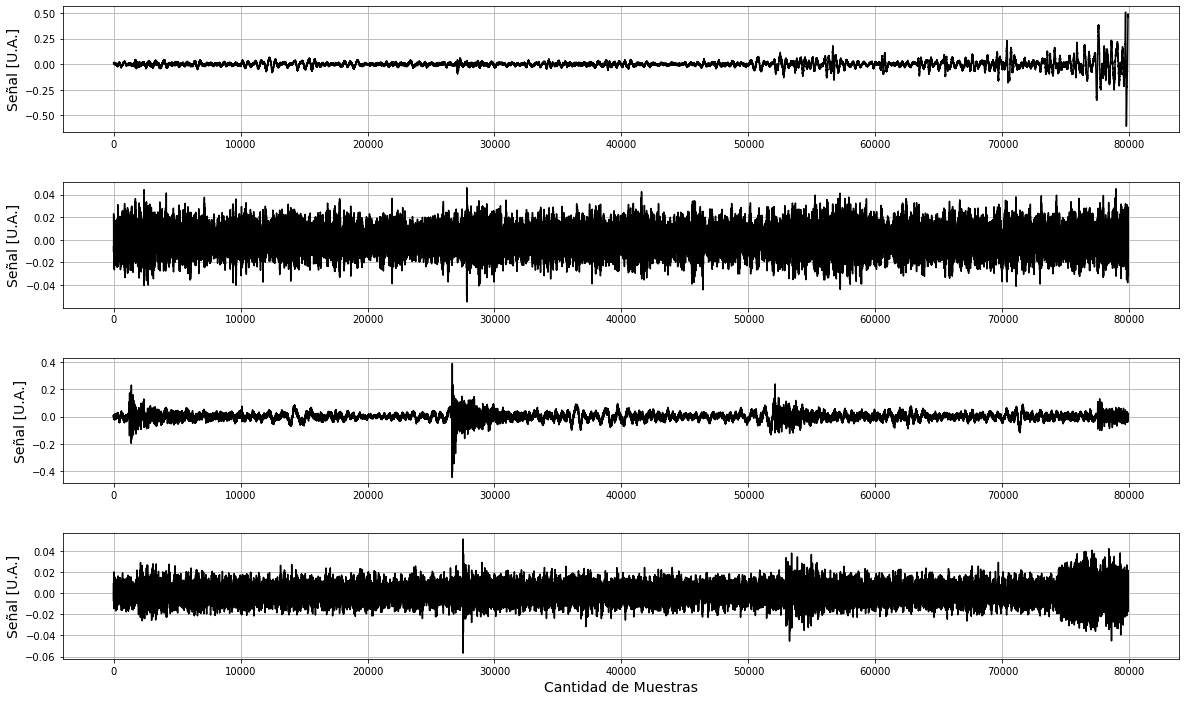

In [ ]:
#now we graphic the signal in every microphone
# Plots
fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, figsize=(20,12))
fig.subplots_adjust(hspace=0.4)



ax1.plot(data1,'k')
#ax1.set_xlabel('Tiempo[s]')
ax1.set_ylabel('Señal [U.A.]',fontsize=14)

ax2.plot(data2,'k')
ax2.set_ylabel('Señal [U.A.]',fontsize=14)
#ax2.set_xlim(0,10000)
#ax2.set_ylim(0,500000)
#ax2.set_xlabel('Frecuencia[Hz]')
#ax2.set_ylabel('FFT [U.A.]')

ax3.plot(data3,'k')
ax3.set_ylabel('Señal [U.A.]',fontsize=14)


ax4.plot(data4,'k')
ax4.set_ylabel('Señal [U.A.]',fontsize=14)
ax4.set_xlabel('Cantidad de Muestras',fontsize=14)



for ax in (ax1, ax2, ax3,ax4): ax.grid()
plt.show()

In [ ]:
audio_clip_band_limited1 = data1
audio_clip_band_limited2 = data2
audio_clip_band_limited3 = data3
audio_clip_band_limited4 = data4


What we observe is a signal with certain pulses, we need to temporarily locate where these pulses are, so with them we can calculate the delay times of the pulses between microphones.
Then, we being able to use this time delays in our algorithm(neural network, model A and model B) to predice positions.This means where the metrophone were it when this pulses were emitted. But this can be a bit difficult as the signal is noisy so we want to apply a filter to get a smoother signal.
We need to make a spectogram to be able to identify the cutoff frequency of our filters

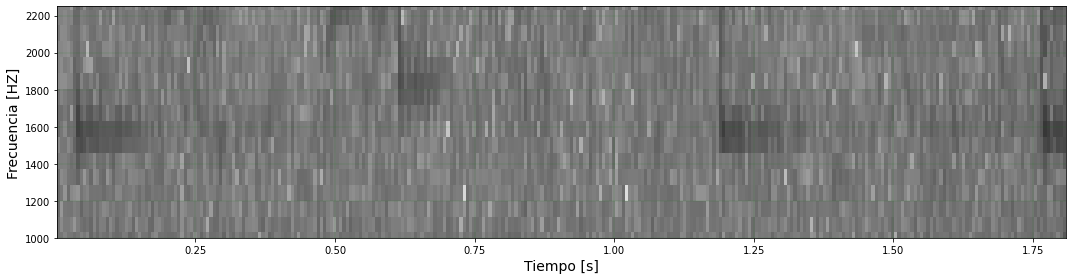

In [ ]:
#SPECTOGRAM
def espectrograma(señal,fs):
    #https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    plt.figure(figsize=(15,4))
    #plt.specgram(señal, NFFT=int(fs*0.005), Fs=fs, cmap=plt.cm.gray, pad_to=256, noverlap=int(fs*0.0025))
    plt.specgram(señal, NFFT= 512 , Fs=fs, noverlap = 256 ,cmap='Greys', mode='magnitude') #detrend='mean'
    plt.xlabel('Tiempo [s]',fontsize=14) #time
    plt.ylabel('Frecuencia [HZ]',fontsize=14) #frequency
    #plt.ylim([0,fs/4])
    plt.ylim(1000,2250)   #after making the spectrogram, we set limits on the y-axis, in the region of interest, to more clearly identify the filters
    plt.tight_layout()
    plt.grid(color='g', linestyle='--', linewidth=0.2)
    plt.show()

espectrograma(data1, rate1
              )

### Stationary remove noise

Now we apply the filters, using the previously defined functions, and the cutoff frequencies

In [ ]:
#filtrado  #FILTER

N=10
fc=1300
fc2=2100
fs= rate1

señal_fil_intermedia1=filtro_pa (audio_clip_band_limited1, fs, N, fc)
audio_clip_band_limited1=filtro_pb(señal_fil_intermedia1, fs,N, fc2)

señal_fil_intermedia2=filtro_pa (audio_clip_band_limited2, fs, N, fc)
audio_clip_band_limited2=filtro_pb(señal_fil_intermedia2, fs,N, fc2 )

señal_fil_intermedia3=filtro_pa (audio_clip_band_limited3, fs, N, fc)
audio_clip_band_limited3=filtro_pb(señal_fil_intermedia3, fs,N, fc2 )

señal_fil_intermedia4=filtro_pa (audio_clip_band_limited4, fs, N, fc)
audio_clip_band_limited4=filtro_pb(señal_fil_intermedia4, fs,N, fc2 )





reduced_noise1 = nr.reduce_noise(y = audio_clip_band_limited1, sr=rate1, n_std_thresh_stationary=1.5,stationary=True)
reduced_noise2 = nr.reduce_noise(y = audio_clip_band_limited2, sr=rate2, n_std_thresh_stationary=1.5,stationary=True)
reduced_noise3 = nr.reduce_noise(y = audio_clip_band_limited3, sr=rate3, n_std_thresh_stationary=1.5,stationary=True)
reduced_noise4 = nr.reduce_noise(y = audio_clip_band_limited4, sr=rate4, n_std_thresh_stationary=1.5,stationary=True)

#normalizo

#reduced_noise1 = reduced_noise1/np.max(reduced_noise1) 
#reduced_noise2 = reduced_noise2/np.max(reduced_noise2) 
#reduced_noise3 = reduced_noise3/np.max(reduced_noise3) 
#reduced_noise4 = reduced_noise4/np.max(reduced_noise4) 

reduced_noise1 = normalizar(reduced_noise1) 
reduced_noise2 = normalizar(reduced_noise2) 
reduced_noise3 = normalizar(reduced_noise3) 
reduced_noise4 = normalizar(reduced_noise4) 


In [ ]:
IPython.display.Audio(data=reduced_noise1, rate=rate1)

We graphic and obtain a smooth signal

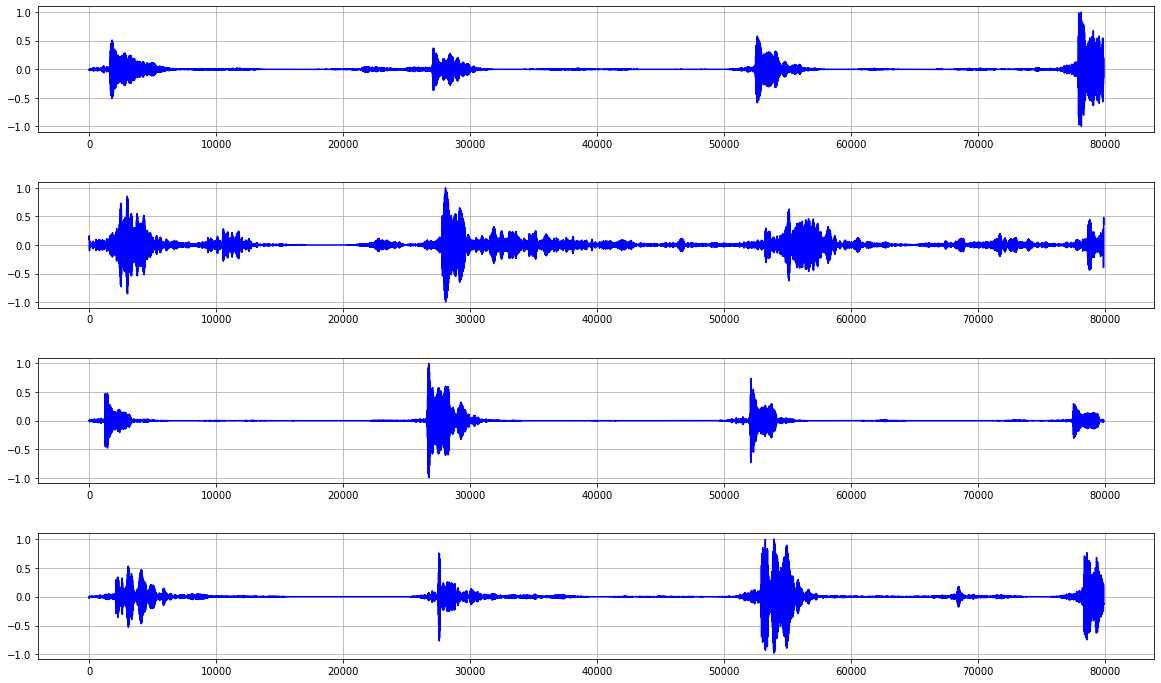

In [ ]:

# Plots
fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, figsize=(20,12))
fig.subplots_adjust(hspace=0.4)



ax1.plot(reduced_noise1,'b')
#ax1.set_xlabel('Tiempo[s]')


ax2.plot(reduced_noise2,'b')
#ax2.set_xlim(0,10000)
#ax2.set_ylim(0,500000)
#ax2.set_xlabel('Frecuencia[Hz]')
#ax2.set_ylabel('FFT [U.A.]')

ax3.plot(reduced_noise3,'b')


ax4.plot(reduced_noise4,'b')



for ax in (ax1, ax2, ax3,ax4): ax.grid()
plt.show()

Now we gonna identify the "peaks" of the pulses, because the time delays gonna be calculated between the microphones with this points. Notice that we will have as many peaks as pulses we have.


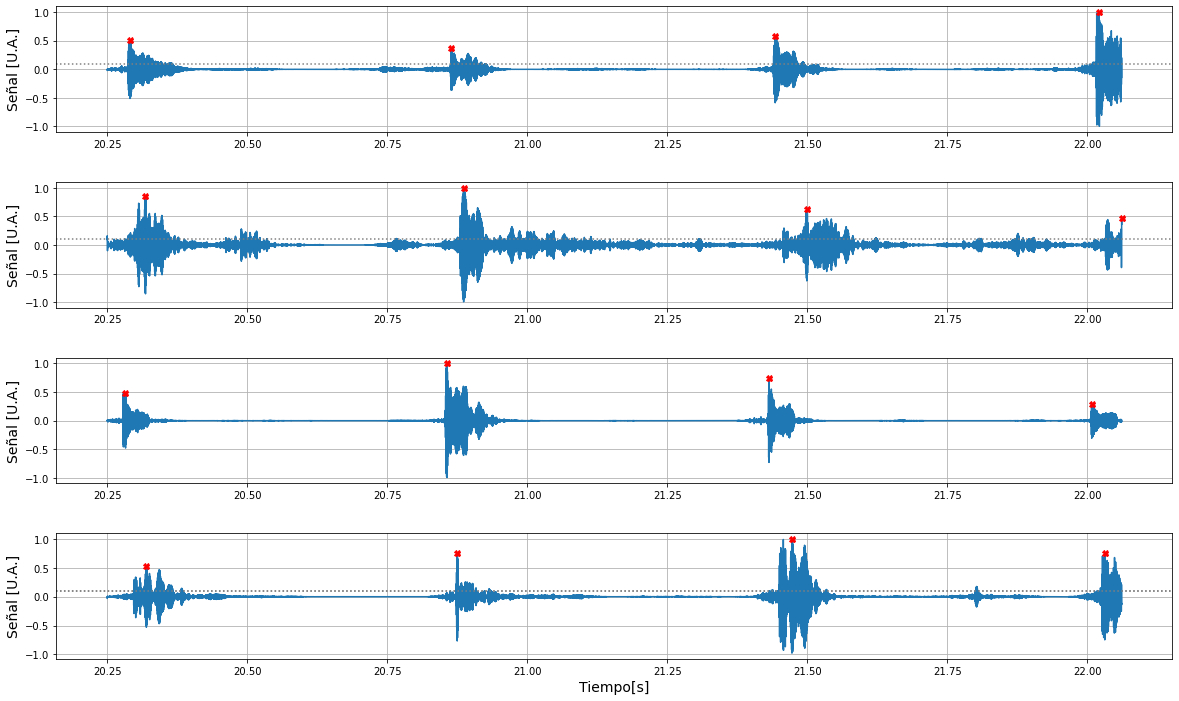

In [ ]:
height = 0.1

peaks1, info1 = find_peaks(reduced_noise1, height=height,distance=15000 ,width=None)
peaks2, info2 = find_peaks(reduced_noise2, height=height,distance=15000 ,width=None)
peaks3, info3 = find_peaks(reduced_noise3, height=height,distance=15000 ,width=None)
peaks4, info4 = find_peaks(reduced_noise4, height=height,distance=15000 ,width=None)

#print(f"Peaks: {len(peaks)}")

#plt.figure(figsize=(20,3))
#plt.plot(time1, reduced_noise1)
#plt.plot(time1[peaks],reduced_noise1[peaks], "x")
#plt.axhline(height, linestyle=":", color='gray');
#plt.xlabel('Tiempo[s]')
#plt.ylabel('Amplitud')

# Plots
fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, figsize=(20,12)) #we create a figure with 4 sub-images, so this figure will have 4 x axes, one for each signal in the microphone
plt.xlabel('Tiempo[s]',fontsize=14) #time
fig.subplots_adjust(hspace=0.4)


ax1.plot(time1, reduced_noise1)
ax1.plot(time1[peaks1],reduced_noise1[peaks1], "Xr")
ax1.axhline(height, linestyle=":", color='gray');
ax1.set_ylabel('Señal [U.A.]',fontsize=14)


ax2.plot(time2, reduced_noise2)
ax2.plot(time2[peaks2],reduced_noise2[peaks2], "Xr")
ax2.axhline(height, linestyle=":", color='gray');
ax2.set_ylabel('Señal [U.A.]',fontsize=14)

ax3.plot(time3, reduced_noise3)
ax3.plot(time3[peaks3],reduced_noise3[peaks3], "Xr")
ax4.axhline(height, linestyle=":", color='gray');
ax3.set_ylabel('Señal [U.A.]',fontsize=14)


ax4.plot(time4, reduced_noise4)
ax4.plot(time4[peaks4],reduced_noise4[peaks4], "X",color='red')
ax4.axhline(height, linestyle=":", color='gray');
ax4.set_ylabel('Señal [U.A.]',fontsize=14)




for ax in (ax1, ax2, ax3,ax4): ax.grid()
plt.show()

Now we gonna calculate all the time delays. For every pulse we gonna have 6 time delays (Between microphones 1-2,1-3,1-4,2-3,2-4,3-4)

In [ ]:

largo=np.arange(len(peaks1)) #because we have 4 pulses
delta=np.array([[0,0,0,0,0,0]]) # in this we are going to calculate the time delays, we have six time delays
for i in largo: #for, to calculate the time delays for each pulse
    b=[[time1[peaks1][i]- time2[peaks2][i], time1[peaks1][i]-time3[peaks3][i], time1[peaks1][i]-time4[peaks4][i],  time2[peaks2][i]-time3[peaks3][i], time2[peaks2][i]-time4[peaks4][i],time3[peaks3][i] - time4[peaks4][i]]]
    delta=np.concatenate((delta, b), axis=0)

delta=delta[1:]
delta

array([[-0.02721088,  0.00848073, -0.02875283,  0.03569161, -0.00154195,
        -0.03723356],
       [-0.02172336,  0.00809524, -0.01029478,  0.02981859,  0.01142857,
        -0.01839002],
       [-0.05648526,  0.01170068, -0.02929705,  0.06818594,  0.02718821,
        -0.04099773],
       [-0.04013605,  0.01362812, -0.01027211,  0.05376417,  0.02986395,
        -0.02390023]])

Now we load our Models of neural networks.

In [ ]:

#model = load_model('/content/drive/MyDrive/Labo 6 y 7/30ep_144000dat_r.h5')
#model = load_model('/content/drive/MyDrive/LABO 6 y 7/2do Cuatrimestre/red2random_20_128_r.h5')

model_A= load_model('/content/drive/MyDrive/LABO 6 y 7//2do Cuatrimestre/modelos/red2random_20_128_r.h5')  
model_B=load_model('/content/drive/MyDrive/LABO 6 y 7/2do Cuatrimestre/modelos/mejor_modelo_20.4_r.h5')




We calculate the median of all the time delays for every pulse, and then we use it as an input to the algorithm (model A, and model B)

In [ ]:
mediana_delta=np.median(delta, axis=0) #median time delays
datos=np.array([mediana_delta]) #array with every median of the dime delays of every pulse

print(datos)
posicion_A=model_A.predict(datos) #now we uses "datos" as an input to the neural networks to predict positions. In this case we use model A
posicion_B=model_B.predict(datos) #We use model B to predict position using "datos"

print('La posicion es A ',posicion_A) #we print the predictions of the position using model A
print('La posicion es B ',posicion_B) #we print the predictions of the position using model A

[[-0.03367347  0.0100907  -0.01952381  0.04472789  0.01930839 -0.03056689]]
La posicion es A  [[ 9.7694801e+01  4.4391827e+01 -5.9293538e-02]]
La posicion es B  [[36.17393    66.81175     0.80864525]]
